In [1]:
import sys
import os
import pickle
import numpy as np
import tensorflow as tf
import gpflow
sys.path.append('../../../../')
import gpitch
from gpitch.amtgp import logistic
from gpitch import myplots
import peakutils
from scipy.fftpack import fft

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= (16, 3)

In [3]:
visible_device = sys.argv[1]  # configure gpu usage
gpitch.amtgp.init_settings(visible_device=visible_device, interactive=True)

In [4]:
saveloc = '../../../../../results/files/svi/notebook/'
fname = '../../../../../datasets/maps/test_data/segment4-down.wav'

In [5]:
y, fs = gpitch.amtgp.wavread(filename=fname, mono=False)  #  the signal is already mono
N = y.size
x = np.linspace(0, (N-1.)/fs, N).reshape(-1, 1)  # time vector

(32000, 1)

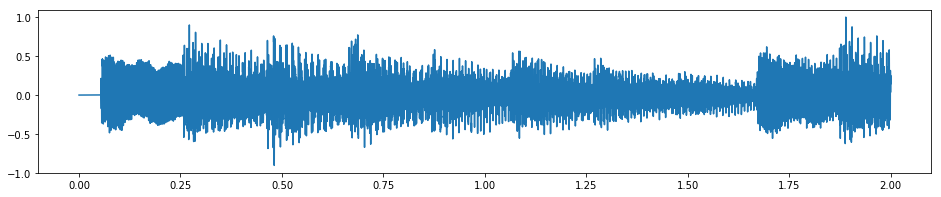

In [6]:
plt.figure()
plt.plot(x, y)
y.shape

In [7]:
dec = 160  # decimation factor
minibatch_size = 200  # batch size svi
maxiter = 5000  #  maximun number of iterations in optimization
learning_rate = 0.01  # learning rate svi optimization

In [8]:
Y = fft(y.reshape(-1,))
S = 2./N * np.abs(Y[:N/2])
F = np.linspace(0, fs/2., N/2)
S /= S.sum()

In [9]:
idx = peakutils.indexes(S, thres=0.0005/max(S), min_dist=100)
F_star, S_star = F[idx], S[idx]
var_scale = S_star.sum()
S_star /= 4.*var_scale 
Nc = F_star.size

(0, 3500)

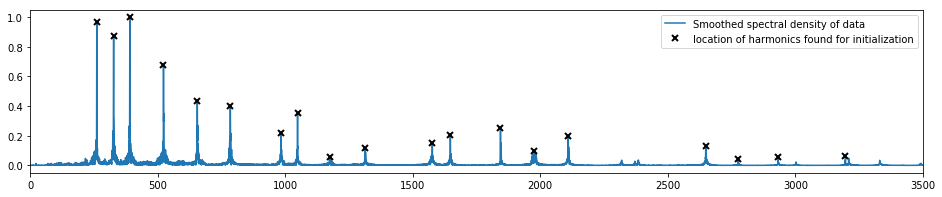

In [10]:
plt.figure()
plt.plot(F, S/np.max(S))
plt.plot(F_star, S_star/np.max(S_star), 'xk', mew=2)
plt.legend(['Smoothed spectral density of data', 'location of harmonics found for initialization'])
plt.xlim([0, 3500])

In [11]:
z = np.vstack((x[::dec].copy(), x[-1].copy()))

kern_com = gpitch.kernels.MaternSpecMix(input_dim=1, lengthscales=0.1, variances=S_star,
                                        frequencies=F_star, Nc=Nc)
kern_act = gpflow.kernels.Matern32(input_dim=1, lengthscales=0.25, variance=10.)

m = gpitch.modgp.ModGP(x=x, y=y, z=z, kern_com=kern_com, kern_act=kern_act, whiten=True,
                       minibatch_size=minibatch_size)

In [ ]:
m.fixed_msmkern_params(freq=False, var=True)
m.kern_com.lengthscales.fixed = False
m.kern_com.lengthscales.transform = gpflow.transforms.Logistic(0., 10.0)
m.kern_act.fixed = False
m.likelihood.variance.fixed = False
m.z.fixed = True

In [ ]:
m.optimize_svi(maxiter=maxiter, learning_rate=learning_rate)

In [ ]:
m

In [ ]:
plt.plot(-np.array(m.logf))
plt.xlabel('iteration')
plt.ylabel('ELBO')

In [ ]:
mean_f, var_f, mean_g, var_g, x_plot  = m.predict_all(x)
xlim = [0.0, 2.0]
myplots.plot_results(mean_f, var_f, mean_g, var_g, x_plot, y, z, xlim)

In [ ]:
prediction = logistic(mean_g)*mean_f
plt.figure()
plt.plot(x, prediction)

In [ ]:
m

In [ ]:
k_plot_model = m.kern_com.compute_K(x, np.asarray(0.).reshape(-1,1))
plt.figure(figsize=(16, 4))
plt.plot(x, k_plot_model, lw=2)

In [ ]:
N = x.size
Yk1 = fft(k_plot_model.reshape(-1,)) #  FFT data
Sk1 =  2./N * np.abs(Yk1[0:N//2]) #  spectral density data

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(F, S / np.max(np.abs(S)), lw=2)
plt.legend([' Spectral density data'])
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 4000])

plt.subplot(2, 1, 2)
plt.plot(F, S / np.max(np.abs(S)), 'r', lw=2)
plt.plot(F, Sk1 / np.max(np.abs(Sk1)), lw=2)
plt.legend([' Spectral density learned component kernel'])
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 4000])

In [ ]:
pickle.dump(m, open(saveloc + "maps_background" + ".p", "wb"))